<a href="https://colab.research.google.com/github/vangelis-michael/Deep-learning-/blob/master/RL_Cartpole_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCEMENT LEARNING ON CARTPOLE GAME

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

# Download repositories
! git clone https://github.com/aamini/introtodeeplearning_labs.git > /dev/null 2>&1
% cd introtodeeplearning_labs
! git pull
% cd ..

/content/introtodeeplearning_labs
Already up to date.
/content


In [0]:
env = gym.make("CartPole-v0")
env.seed(1) # reproducible, since RL has high variance

[1]

In [0]:
print("Environment has observation space = {}".format(env.observation_space))

Environment has observation space = Box(4,)


In [0]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 2


### Define the Agent

In [0]:
def create_cartpole_model():
  
  model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=32, activation='relu'), 
                                        tf.keras.layers.Dense(units=n_actions, activation=None)
                                       ])
  return model

cartpole_model = create_cartpole_model()

In [0]:
def choose_action(model, observation):
    observation = observation.reshape([1, -1])
    logits = model.predict(observation)
    
    prob_weights = tf.nn.softmax(logits).numpy()
    
    action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]
    
    return action

In [0]:
class Memory:
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        
    def add_to_memory(self, new_observation, new_action, new_reward):
        self.observations.append(new_observation)
        self.actions.append(new_action)
        self.rewards.append(new_reward)
        
memory = Memory()

In [0]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x

def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)


In [0]:
learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate)

In [0]:
def compute_loss(logits, actions, rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    loss = tf.reduce_mean( neg_logprob * rewards )
    return loss

In [0]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
    with tf.GradientTape() as tape:
        observations = tf.convert_to_tensor(observations, dtype=tf.float32)
        logits = model(observations)
        
        loss = compute_loss(logits, actions, discounted_rewards)
        
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

In [0]:
class LossHistory:
    def __init__(self, smoothing_factor=0.0):
        self.alpha = smoothing_factor
        self.loss = []
    def append(self, value):
        self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
    def get(self):
        return self.loss
    
class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):
        from IPython import display as ipythondisplay
        import matplotlib.pyplot as plt
        import time
        
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale
        
        self.tic = time.time()
        
    def plot(self, data):
        if time.time() - self.tic > self.sec:
            plt.cla()  
            
            if self.scale is None:
                plt.plot(data)
            elif self.scale == 'semilogx':
                plt.semilogx(data)
            elif self.scale == 'semilogy':
                plt.semilogy(data)
            elif self.scale == 'loglog':
                plt.loglog(data)
            else:
                raise ValueError("unrecognized parameter scale {}".format(self.scale))
                
            plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
            self.tic = time.time()

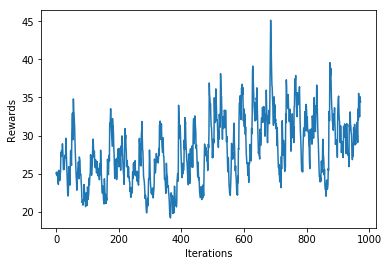

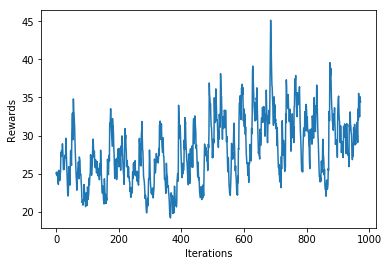

In [0]:
cartpole_model = create_cartpole_model()

smoothed_reward = LossHistory(smoothing_factor=0.9)
plotter = PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')

for i_episode in range(1000):
    plotter.plot(smoothed_reward.get())
    
    observation = env.reset()
    
    while True:
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        
        memory.add_to_memory(observation, action, reward)
        
        if done:
            total_reward = sum(memory.rewards)
            smoothed_reward.append( total_reward )
            
            train_step(cartpole_model, optimizer, observations = np.vstack(memory.observations), 
                       actions = np.array(memory.actions), 
                       discounted_rewards = discount_rewards(memory.rewards))
            memory.clear()
            break
            
        observation = next_observation

In [0]:
def save_video_of_model(model, env_name, filename='agent1.mp4'):
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible= 0, size =(40, 30))
    display.start()
    
    env = gym.make(env_name)
    obs = env.reset()
    shape = env.render(mode='rgb_array').shape[0:2]
    
    out = skvideo.io.FFmpegWriter(filename)
    
    done = False
    while not done:
        frame = env.render(mode = 'rgb_array')
        out.writeFrame(frame)
        
        action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
        obs, reward, done, info = env.step(action)
    out.close()
    print("Successfully saved into {}!".format(filename))
    
save_video_of_model(cartpole_model, "CartPole-v0")

Successfully saved into agent1.mp4!


In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./agent1.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
  <source src="data:video/mp4;base64,{0}" type="video/mp4" />

</video>'''.format(encoded.decode('ascii')))

In [0]:
ls

agent.mp4  introtodeeplearning_labs/  sample_data/


In [0]:
from google.colab import files
files.download('agent.mp4')

In [0]:
tf.reset_default_graph()